In [78]:
from poutyne import Model
from copy import deepcopy  # NEW
from scipy.stats import bernoulli

import numpy as np
import gym
import torch
import random


from collections import deque

class ReplayBuffer:
    def __init__(self, buffer_size):
        self.__buffer_size = buffer_size
        # TODO : Add any needed attributes
        self.data = deque(maxlen=int(buffer_size))

    def store(self, element):
        """
        Stores an element. If the replay buffer is already full, deletes the oldest
        element to make space.
        """
        # TODO : Implement
        self.data.append(element)
        pass

    def get_batch(self, batch_size):
        """
        Returns a list of batch_size elements from the buffer.
        """
        buffer_list = list(self.data)
        return random.sample(buffer_list, batch_size)


class DQN(Model):
    def __init__(self, actions, *args, **kwargs):
        self.actions = actions
        super().__init__(*args, **kwargs)

    def get_action(self, state, epsilon):
        """
        Returns the selected action according to an epsilon-greedy policy.
        """
        # TODO: implement
        if bernoulli.rvs(epsilon):
            action = random.choice(self.actions)
        else:
            pred_r = self.predict(state)
            action = self.actions[np.argmax(pred_r)]
        return action


    def soft_update(self, other, tau):
        """
        Code for the soft update between a target network (self) and
        a source network (other).

        The weights are updated according to the rule in the assignment.
        """
        new_weights = {}

        own_weights = self.get_weight_copies()
        other_weights = other.get_weight_copies()

        for k in own_weights:
            new_weights[k] = (1 - tau) * own_weights[k] + tau * other_weights[k]

        self.set_weights(new_weights)


class NNModel(torch.nn.Module):
    """
    Neural Network with 3 hidden layers of hidden dimension 64.
    """

    def __init__(self, in_dim, out_dim, n_hidden_layers=3, hidden_dim=64):
        super().__init__()
        layers = [torch.nn.Linear(in_dim, hidden_dim), torch.nn.ReLU()]
        for _ in range(n_hidden_layers - 1):
            layers.extend([torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.ReLU()])
        layers.append(torch.nn.Linear(hidden_dim, out_dim))

        self.fa = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.fa(x)


def format_batch(batch, target_network, gamma):
    """
    Input : 
        - batch, a list of n=batch_size elements from the replay buffer
        - target_network, the target network to compute the one-step lookahead target
        - gamma, the discount factor

    Returns :
        - states, a numpy array of size (batch_size, state_dim) containing the states in the batch
        - (actions, targets) : where actions and targets both
                      have the shape (batch_size, ). Actions are the 
                      selected actions according to the target network
                      and targets are the one-step lookahead targets.
    """
    # TODO: Implement

    states = np.array([x[0] for x in batch])
    actions_taken = np.array([x[1] for x in batch])
    rewards = np.array([x[2] for x in batch])
    next_states = np.array([x[3] for x in batch])
    terminal = np.array([x[4] for x in batch])

    next_qvals_predicted = target_network.predict(next_states)

    next_actions_vals_selected = np.max(next_qvals_predicted, axis=1)

    targets = rewards + gamma * next_actions_vals_selected * (1 - terminal)

    act_targ = (actions_taken.astype(np.int64), targets.astype(np.float32))

    return states, act_targ


def dqn_loss(y_pred, y_target):
    """
    Input :
        - y_pred, (batch_size, n_actions) Tensor outputted by the network
        - y_target = (actions, targets), where actions and targets both
                      have the shape (batch_size, ). Actions are the 
                      selected actions according to the target network
                      and targets are the one-step lookahead targets.

    Returns :
        - The DQN loss 
    """
    # C'est essentiellement le même travail que ce qui est fait dans update_theta
    # sauf (1) qu'on le fait en PyTorch et les fonctions n'ont pas le même nom
    # et (2) on ne calcule pas le gradient nous-mêmes, on fait juste donner la perte.
    # C'est PyTorch qui fait la descente de gradient pour nous.

    actions, targets = y_target
    q_pred = y_pred.gather(1, actions.unsqueeze(-1)).squeeze()

    return torch.nn.functional.mse_loss(q_pred, targets)

def set_random_seed(environment, seed):
    environment.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)  # NEW


def run_dqn(agent, seed=42):
    environment = gym.make("LunarLander-v2")
    set_random_seed(environment, seed=seed)

    env = gym.wrappers.Monitor(environment, "demo", force=True)

    done = False
    s = environment.reset().astype(np.float32)
    
    ##pour enregistrer les gains pour faire un graphique au début
    r_liste=[]
    
    while not done:
        env.render()
        q_vals = agent.predict(s)
        action = np.argmax(q_vals)
        next_s, r, done, _ = environment.step(action)

        s = next_s.astype(np.float32)
        
        ##Stock le gain
        r_liste.append(r)
        
    env.close()
    
    ###return les gains instantanés (les rewards pour chaque pas)
    return r_liste



In [79]:
# NEW : Added lr argument
def main(batch_size, gamma, buffer_size, seed, tau, training_interval, lr):
    environment = gym.make("LunarLander-v2")
    set_random_seed(environment, seed)

    actions = list(range(environment.action_space.n))
    model = NNModel(environment.observation_space.shape[0], environment.action_space.n)
    policy_net = DQN(
        actions,
        model,
        optimizer=torch.optim.Adam(model.parameters(), lr=lr),
        loss_function=dqn_loss,
    )
    # NEW: pass a deep copy of the model
    target_net = DQN(actions, deepcopy(model), optimizer="sgd", loss_function=dqn_loss,)
    replay_buffer = ReplayBuffer(buffer_size)

    training_done = False
    episodes_done = 0
    steps_done = 0
    epsilon = 1.0
    epsilon_decay = 0.95
    epsilon_min = 0.01
    n = 5 # Nombre d'épisodes de suite pour lequel la moyenne doit être >= 200 pour que l'apprentissage arrête 
    G_liste = [] #Pour emmagasiner le gain cumulé après chaque épisode
    loss_liste = [] #Pour emmagasiner la perte après chaque épisode

    while not training_done:
        s = environment.reset()
        episode_done = False
        G = 0
        while not episode_done:
            a = policy_net.get_action(s, epsilon)
            next_s, r, episode_done, _ = environment.step(a)
            replay_buffer.store((s, a, r, next_s, episode_done))
            s = next_s
            steps_done += 1
            G += r

            if steps_done % training_interval == 0:
                if len(replay_buffer.data) >= batch_size:
                    batch = replay_buffer.get_batch(batch_size)
                    x, y = format_batch(batch, target_net, gamma)
                    loss = policy_net.train_on_batch(x, y)
                    target_net.soft_update(policy_net, tau)

        # TODO: update epsilon
        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        
        episodes_done += 1
        
        G_liste.append(G)
        loss_liste.append(loss)
        
        if episodes_done > n and np.mean(G_liste[-n:]) >= 200:
            training_done = True

        if (episodes_done) % 1 == 0:
            print(f"After {episodes_done} trajectoires, we have G_0 = {G:.2f}, {epsilon:4f}")

    return policy_net, G_liste, loss_liste, episodes_done

In [80]:
if __name__ == "__main__":
    """
    All hyperparameter values and overall code structure are
    only given as a baseline. 
    
    You can use them if they help  you, but feel free to implement
    from scratch the required algorithms if you wish !
    """
    batch_size = 32
    gamma = 0.99
    buffer_size = 1e5
    seed = 42
    tau = 1e-2
    training_interval = 4
    lr = 5e-4  # NEW lr as parameter

    # NEW : pass lr to main()
    dqn, Gains, Loss, n_episodes = main(batch_size, gamma, buffer_size, seed, tau, training_interval, lr)

After 1 trajectoires, we have G_0 = -105.08, 0.950000
After 2 trajectoires, we have G_0 = -167.85, 0.902500
After 3 trajectoires, we have G_0 = -201.74, 0.857375
After 4 trajectoires, we have G_0 = -119.20, 0.814506
After 5 trajectoires, we have G_0 = -316.46, 0.773781
After 6 trajectoires, we have G_0 = -108.35, 0.735092
After 7 trajectoires, we have G_0 = -274.96, 0.698337
After 8 trajectoires, we have G_0 = -377.63, 0.663420
After 9 trajectoires, we have G_0 = -352.86, 0.630249
After 10 trajectoires, we have G_0 = -549.25, 0.598737
After 11 trajectoires, we have G_0 = -310.17, 0.568800
After 12 trajectoires, we have G_0 = -196.81, 0.540360
After 13 trajectoires, we have G_0 = -131.49, 0.513342
After 14 trajectoires, we have G_0 = -177.32, 0.487675
After 15 trajectoires, we have G_0 = -155.16, 0.463291
After 16 trajectoires, we have G_0 = 20.11, 0.440127
After 17 trajectoires, we have G_0 = -212.80, 0.418120
After 18 trajectoires, we have G_0 = -434.48, 0.397214
After 19 trajectoires

After 152 trajectoires, we have G_0 = -26.19, 0.010000
After 153 trajectoires, we have G_0 = -90.12, 0.010000
After 154 trajectoires, we have G_0 = -69.20, 0.010000
After 155 trajectoires, we have G_0 = -55.63, 0.010000
After 156 trajectoires, we have G_0 = -35.88, 0.010000
After 157 trajectoires, we have G_0 = -41.93, 0.010000
After 158 trajectoires, we have G_0 = -7.49, 0.010000
After 159 trajectoires, we have G_0 = -78.70, 0.010000
After 160 trajectoires, we have G_0 = -86.97, 0.010000
After 161 trajectoires, we have G_0 = -35.42, 0.010000
After 162 trajectoires, we have G_0 = -268.97, 0.010000
After 163 trajectoires, we have G_0 = -14.36, 0.010000
After 164 trajectoires, we have G_0 = -53.98, 0.010000
After 165 trajectoires, we have G_0 = -50.63, 0.010000
After 166 trajectoires, we have G_0 = -53.15, 0.010000
After 167 trajectoires, we have G_0 = -50.66, 0.010000
After 168 trajectoires, we have G_0 = 291.57, 0.010000
After 169 trajectoires, we have G_0 = -36.78, 0.010000
After 170 

After 302 trajectoires, we have G_0 = 162.71, 0.010000
After 303 trajectoires, we have G_0 = 162.35, 0.010000
After 304 trajectoires, we have G_0 = 15.26, 0.010000
After 305 trajectoires, we have G_0 = 5.48, 0.010000
After 306 trajectoires, we have G_0 = -177.66, 0.010000
After 307 trajectoires, we have G_0 = 155.18, 0.010000
After 308 trajectoires, we have G_0 = 13.62, 0.010000
After 309 trajectoires, we have G_0 = 22.45, 0.010000
After 310 trajectoires, we have G_0 = 32.82, 0.010000
After 311 trajectoires, we have G_0 = -51.35, 0.010000
After 312 trajectoires, we have G_0 = 213.55, 0.010000
After 313 trajectoires, we have G_0 = 2.14, 0.010000
After 314 trajectoires, we have G_0 = -65.09, 0.010000
After 315 trajectoires, we have G_0 = -54.33, 0.010000
After 316 trajectoires, we have G_0 = -28.97, 0.010000
After 317 trajectoires, we have G_0 = -6.55, 0.010000
After 318 trajectoires, we have G_0 = 10.97, 0.010000
After 319 trajectoires, we have G_0 = 149.50, 0.010000
After 320 trajectoi

In [81]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)

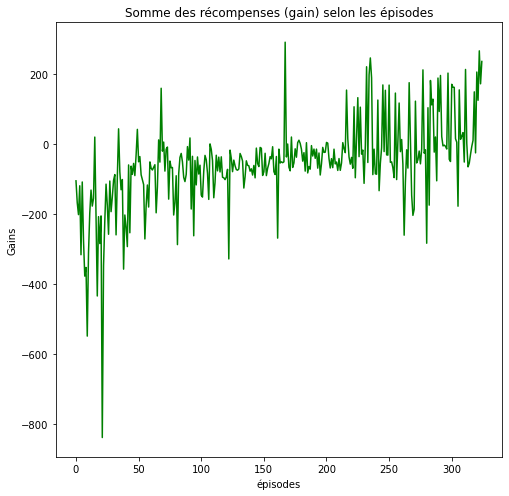

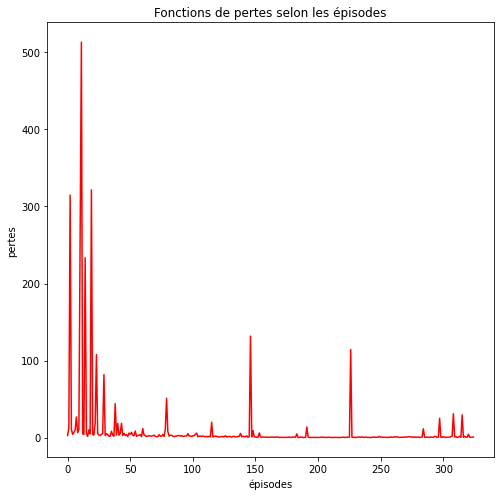

In [89]:
plt.plot(range(n_episodes), Gains, color='green')
plt.xlabel('épisodes')
plt.ylabel('Gains')
plt.title('Somme des récompenses (gain) selon les épisodes')
plt.savefig("gains_convergence_rapide.pdf", bbox_inches='tight')
plt.show()
plt.plot(range(n_episodes), Loss, color='red')
plt.xlabel('épisodes')
plt.ylabel('pertes')
plt.title('Fonctions de pertes selon les épisodes')
plt.savefig("pertes_convergence_rapide.pdf", bbox_inches='tight')
plt.show()

In [98]:
r_liste=run_dqn(dqn,seed=26)

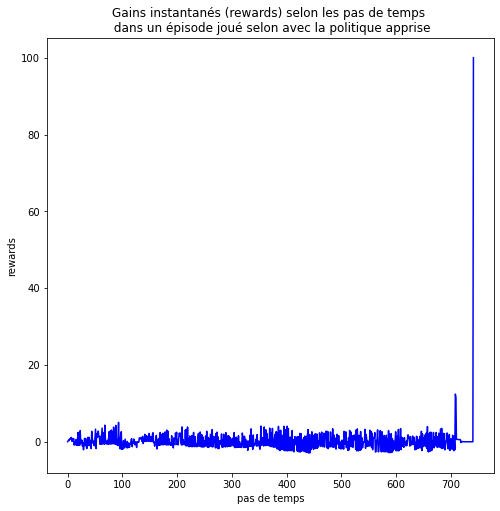

In [99]:
plt.plot(range(len(r_liste)), r_liste, color='blue')
plt.xlabel('pas de temps')
plt.ylabel('rewards')
plt.title('Gains instantanés (rewards) selon les pas de temps \n dans un épisode joué selon avec la politique apprise')
plt.savefig("gain_par_pas_apres_cv.pdf", bbox_inches='tight')
plt.show()

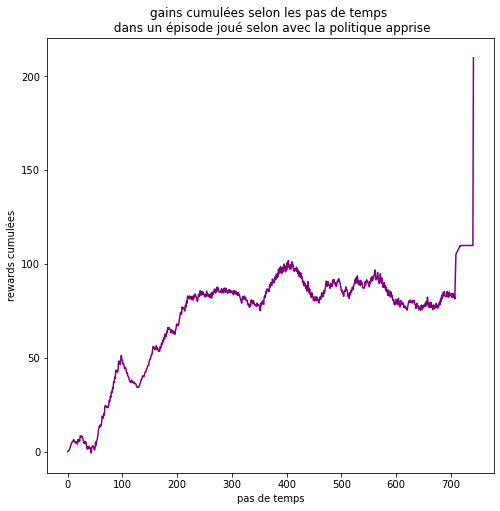

In [100]:
plt.plot(range(len(r_liste)), np.cumsum(r_liste), color='purple')
plt.xlabel('pas de temps')
plt.ylabel('rewards cumulées')
plt.title('gains cumulées selon les pas de temps \n dans un épisode joué selon avec la politique apprise')
plt.savefig("gains_cumules_par_pas_apres_cv.pdf", bbox_inches='tight')
plt.show()

In [9]:
run_dqn(dqn,seed=57)

[0.026705596937119935,
 0.001954575003253467,
 -0.013746081785370734,
 -0.037122023695445705,
 -0.06545818304553563,
 -0.09873086852573465,
 -0.13698639942006707,
 -0.1800706708150983,
 -0.2278875387771393,
 -0.2800446688099214,
 -0.33621329793052723,
 -0.39585845896664296,
 -0.45844105972906846,
 -0.523190538288361,
 -0.5894684822864065,
 0.6122788624167594,
 0.7078176926237074,
 1.013594918314625,
 1.029668291048382,
 1.2999929643348491,
 1.2804763198032003,
 1.1030903832526644,
 1.5524822297429648,
 2.9423076894179134,
 1.497153674317418,
 3.214072112062337,
 -0.5225765478995175,
 0.009906156688242629,
 1.252020441854513,
 0.16375890534460497,
 0.2510799103598174,
 -0.6383771308143935,
 -0.6986687253457149,
 -2.519816937012705,
 1.4120134982774573,
 -2.071354464948682,
 0.7670014066022304,
 -2.0917896722114038,
 -1.5230179826477752,
 -0.8690016354535317,
 -2.0027300236366714,
 -0.6694079909422499,
 1.6879466689969547,
 -0.9407839946284924,
 -1.631195989074057,
 0.2066489090465325,
 

In [10]:
run_dqn(dqn,seed=99)

[-1.435112821492878,
 -2.833899488904193,
 -0.6545402703745709,
 0.28459050385829415,
 2.2363059093200777,
 -3.0302675918380144,
 0.9986530530998721,
 -0.9420532708051326,
 -0.2350219341789625,
 0.6383031324396882,
 -1.683601593423133,
 2.0707876938917424,
 -3.7174864201487194,
 2.1084521063774844,
 -3.271169600011137,
 2.1898610388954296,
 -1.3854278778168976,
 -1.3322912458855,
 0.30712674630335074,
 -0.4478469158099745,
 -0.843660056687088,
 -2.4967710791741977,
 1.8735296668687056,
 -2.8834001785771646,
 1.4537100307923083,
 -1.6410509126768773,
 2.350050321551521,
 -2.407607749661507,
 0.592530080194831,
 -0.12760864773187564,
 -0.09587351294389918,
 0.023913540377179743,
 -1.6687806193922257,
 -1.323963259496054,
 -0.883658091844086,
 -0.09104232742287194,
 -0.5543262992589746,
 -1.4268267846520075,
 -0.04135177836851084,
 -0.35927821056118886,
 -0.8120844343612816,
 0.18390131185519182,
 -0.5224920573294582,
 -1.0960291964549072,
 -0.6594423598771357,
 -0.7408030939328398,
 -1.0